In [1]:
# Part 1: Dataset Loading
import pandas as pd
import numpy as np
from openeye import oechem, oeomega, oeshape
oechem.OEAddLicenseData(open(r"C:\Users\Admin\.OpenEye\oe_license.txt").read())

df = pd.read_csv("antiviral_potency_2025_unblinded.csv")
print(f"Dataset size: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Dataset size: 1328
Columns: ['CXSMILES', 'Molecule Name', 'Set', 'pIC50 (MERS-CoV Mpro)', 'pIC50 (SARS-CoV-2 Mpro)']


,CXSMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro)
0,COC[C@]1(C)C(=O)N(C2=CN=CC3=CC=CC=C23)C(=O)N1C...,ASAP-0000141,Train,4.19,NaN
1,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000142,Train,4.92,5.29
2,CNC(=O)CN1C[C@]2(C[C@H](C)N(C3=CN=CC=C3C3CC3)C...,ASAP-0000143,Train,4.73,NaN
3,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000144,Train,4.90,6.11
4,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000145,Train,4.81,5.62


In [2]:
# Dataset exploration
sars_col = "pIC50 (SARS-CoV-2 Mpro)"
mers_col = "pIC50 (MERS-CoV Mpro)"

print("--- Missing Values ---")
for col in df.columns:
    missing = df[col].isna().sum()
    print(f"  {col}: {missing} missing out of {len(df)}")

print(f"\n--- Train/Test Split ---")
print(df["Set"].value_counts())

sars_valid = df[sars_col].dropna()
print(f"\n--- pIC50 SARS-CoV-2 Statistics ---")
print(f"  Valid values: {len(sars_valid)} out of {len(df)}")
print(f"  Mean: {sars_valid.mean():.3f}")
print(f"  Min:  {sars_valid.min():.3f}")
print(f"  Max:  {sars_valid.max():.3f}")

--- Missing Values ---
  CXSMILES: 0 missing out of 1328
  Molecule Name: 0 missing out of 1328
  Set: 0 missing out of 1328
  pIC50 (MERS-CoV Mpro): 130 missing out of 1328
  pIC50 (SARS-CoV-2 Mpro): 223 missing out of 1328

--- Train/Test Split ---
Set
Train    1031
Test      297
Name: count, dtype: int64

--- pIC50 SARS-CoV-2 Statistics ---
  Valid values: 1105 out of 1328
  Mean: 5.544
  Min:  4.000
  Max:  8.730


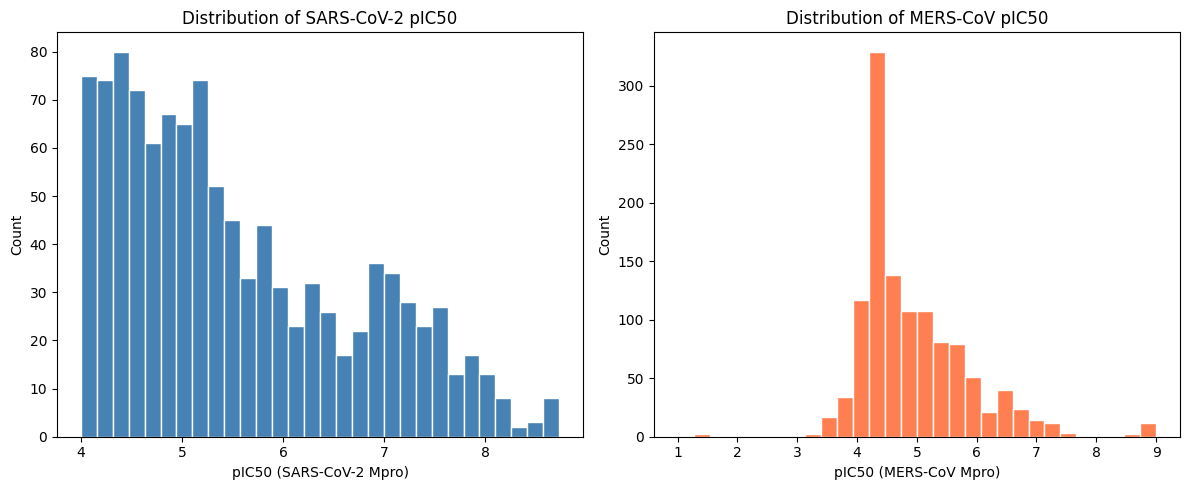

In [3]:
# pIC50 distribution plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df[sars_col].dropna(), bins=30, color="steelblue", edgecolor="white")
axes[0].set_xlabel("pIC50 (SARS-CoV-2 Mpro)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of SARS-CoV-2 pIC50")

axes[1].hist(df[mers_col].dropna(), bins=30, color="coral", edgecolor="white")
axes[1].set_xlabel("pIC50 (MERS-CoV Mpro)")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of MERS-CoV pIC50")

plt.tight_layout()
plt.show()

In [4]:
# Part 2: Feature Generation - OMEGA (SMILES -> 3D conformers)
df_valid = df.dropna(subset=[sars_col]).copy()
print(f"Molecules with valid SARS-CoV-2 pIC50: {len(df_valid)}")

omega_opts = oeomega.OEOmegaOptions(oeomega.OEOmegaSampling_ROCS)
omega = oeomega.OEOmega(omega_opts)

mols_3d = []
skipped = 0

for smiles, name, pic50 in zip(df_valid["CXSMILES"],
                                df_valid["Molecule Name"],
                                df_valid[sars_col]):
    mol = oechem.OEMol()
    oechem.OESmilesToMol(mol, smiles)
    ret_code = omega.Build(mol)
    if ret_code == oeomega.OEOmegaReturnCode_Success:
        mol.SetTitle(name)
        oechem.OESetSDData(mol, "pIC50", str(pic50))
        mols_3d.append(oechem.OEMol(mol))
    else:
        skipped += 1

print(f"3D conformers generated: {len(mols_3d)}")
print(f"Skipped (failed): {skipped}")

Molecules with valid SARS-CoV-2 pIC50: 1105
3D conformers generated: 1087
Skipped (failed): 18


In [5]:
# Part 2: ROCS all-vs-all comparison (demo with 50 molecules)
demo_mols = mols_3d[:50]
n = len(demo_mols)
print(f"Computing {n} x {n} ROCS similarity matrix...")

output_matrix = np.zeros((n, n))
prep = oeshape.OEOverlapPrep()

for q_idx in range(n):
    query = oechem.OEMol(demo_mols[q_idx])
    prep.Prep(query)
    overlay = oeshape.OEOverlay()
    overlay.SetupRef(query)

    for f_idx in range(n):
        fitmol = oechem.OEMol(demo_mols[f_idx])
        prep.Prep(fitmol)
        score = oeshape.OEBestOverlayScore()
        overlay.BestOverlay(score, fitmol)
        output_matrix[q_idx][f_idx] = score.GetTanimotoCombo()

    if (q_idx + 1) % 10 == 0:
        print(f"  Processed {q_idx + 1}/{n} molecules...")

print(f"\nDone! Matrix shape: {output_matrix.shape}")
print(f"Score range: {output_matrix.min():.3f} to {output_matrix.max():.3f}")

Computing 50 x 50 ROCS similarity matrix...
  Processed 10/50 molecules...
  Processed 20/50 molecules...
  Processed 30/50 molecules...
  Processed 40/50 molecules...
  Processed 50/50 molecules...

Done! Matrix shape: (50, 50)
Score range: 0.510 to 2.000


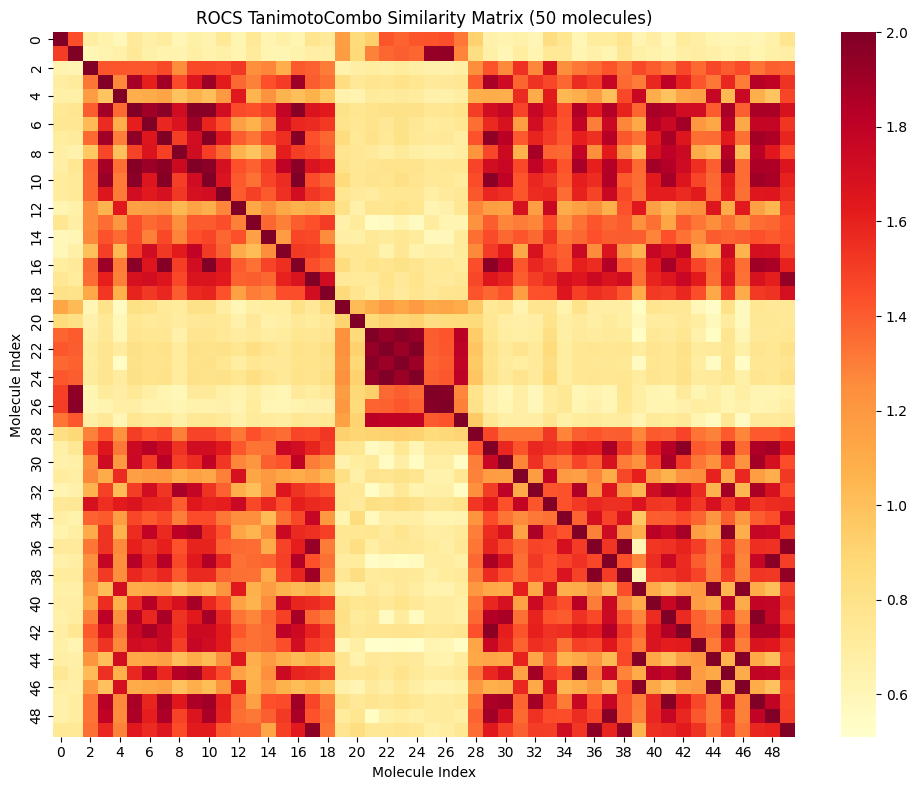

In [6]:
# Part 3: Exploratory Analysis - ROCS similarity heatmap
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(output_matrix, cmap="YlOrRd", ax=ax)
ax.set_title("ROCS TanimotoCombo Similarity Matrix (50 molecules)")
ax.set_xlabel("Molecule Index")
ax.set_ylabel("Molecule Index")
plt.tight_layout()
plt.show()

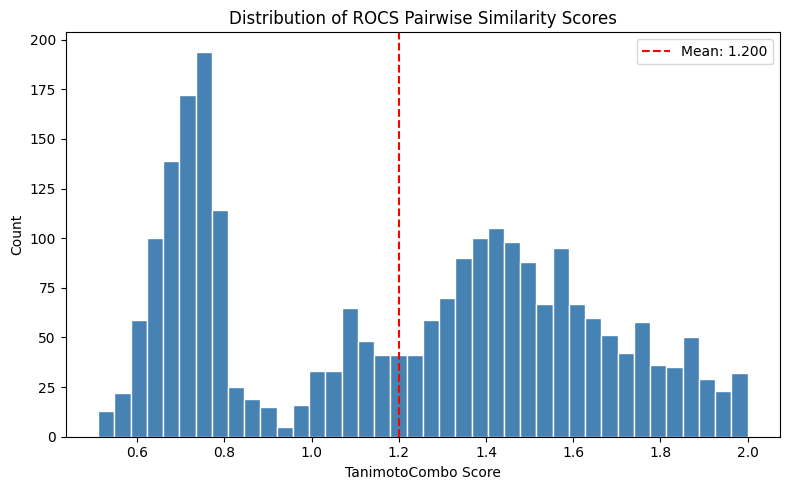

In [7]:
# ROCS combo score distribution (off-diagonal values only)
mask = ~np.eye(n, dtype=bool)
off_diag = output_matrix[mask]

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(off_diag, bins=40, color="steelblue", edgecolor="white")
ax.set_xlabel("TanimotoCombo Score")
ax.set_ylabel("Count")
ax.set_title("Distribution of ROCS Pairwise Similarity Scores")
ax.axvline(x=np.mean(off_diag), color="red", linestyle="--",
           label=f"Mean: {np.mean(off_diag):.3f}")
ax.legend()
plt.tight_layout()
plt.show()

# Individual Contribution

Student: Yung-Chen Lin 
Group 1: 3D Shape and Pharmacophore Features

What I did:
I loaded the Polaris dataset and explored the basic structure, including missing values and the train/test split. Then I used OpenEye OMEGA to convert SMILES into 3D conformers, and used ROCS to compute shape and pharmacophore similarity scores between 50 molecules as a demo.

What I learned:
The hardest part was understanding how OMEGA and ROCS work together. I didn't realize molecules needed to be converted to 3D before you could compare their shapes. The heatmap was interesting because I could see some molecules are very similar to each other while others are quite different. I also learned that the all-vs-all similarity matrix can be used directly as features for ML models.